<a href="https://colab.research.google.com/github/nichd36/Outpaint-Test/blob/main/OutpaintingControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing packages from requirements.txt

In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


# Importing libraries

In [3]:
import random
import torch
import sympy
from PIL import Image, ImageOps
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Setup ControlNet and Pipeline

In [4]:
controlnet = ControlNetModel.from_pretrained(
    "destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype=torch.float16, variant="fp16"
)
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "RunDiffusion/Juggernaut-XL-v9",
    torch_dtype=torch.float16,
    variant="fp16",
    controlnet=controlnet,
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Putting in prompt

In [5]:
prompt = input("Kindly put in your prompt: ")
negative_prompt = "lowres, error, cropped, worst quality, low quality, jpeg artifacts, out of frame, watermark, signature"

Kindly put in your prompt: A person sitting in a chair


# Entering image file path

In [6]:
uploaded_image_path = input("Enter the path to your image file (jpg, png, jpeg): ")

Enter the path to your image file (jpg, png, jpeg): photoOutpaint.jpeg


# Selecting expansion direction, 100 pixels for each direction

In [7]:
print("Expand to:")
left = input("Expand left? (yes/no): ").strip().lower() == "yes"
right = input("Expand right? (yes/no): ").strip().lower() == "yes"
up = input("Expand up? (yes/no): ").strip().lower() == "yes"
down = input("Expand down? (yes/no): ").strip().lower() == "yes"

Expand to:
Expand left? (yes/no): yes
Expand right? (yes/no): yes
Expand up? (yes/no): no
Expand down? (yes/no): yes


# Exporting the padded image for reference

In [8]:
try:
    if uploaded_image_path:
        seed = random.randint(0, 2**32 - 1)

        image = Image.open(uploaded_image_path).convert("RGB")
        border_left = 100 if left else 0
        border_up = 100 if up else 0
        border_right = 100 if right else 0
        border_down = 100 if down else 0

        padded_image = ImageOps.expand(
            image, border=(border_left, border_up, border_right, border_down), fill=(255, 255, 255)
        )

        padded_image_path = "padded_image.jpg"
        padded_image.save(padded_image_path)
    else:
        print("No image uploaded.")
except Exception as e:
    print(f"Error processing image: {e}")

# Exporting expanded photo with outpainting

In [9]:
expanded_image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=padded_image.height,
        width=padded_image.width,
        guidance_scale=6.5,
        num_inference_steps=25,
        image=padded_image,
        controlnet_conditioning_scale=0.9,
        control_guidance_end=0.9,
    ).images[0]

expanded_image_path = "expanded_image.jpg"
expanded_image.save(expanded_image_path)

  0%|          | 0/25 [00:00<?, ?it/s]

#### Show outpainted image

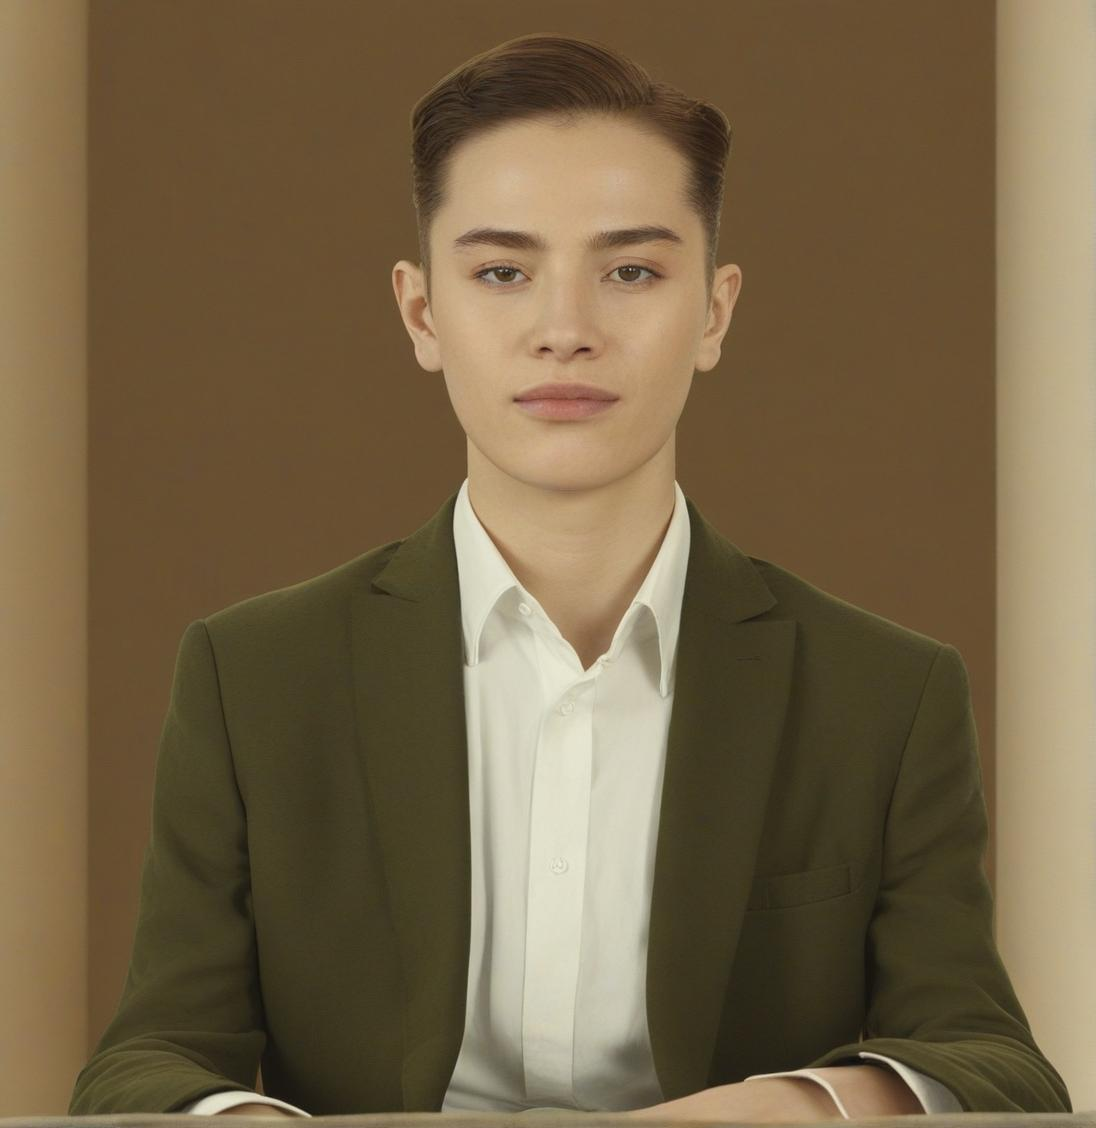

In [10]:
from IPython.display import Image
Image(filename='expanded_image.jpg')